In [11]:
from core.model_data import Parameters
from generator.context import SNVGeneratorContext
from generator.gen import SNVModelGenerator, sample_cells_data

from typing import List, Tuple
import numpy as np
import random

In [2]:
class GeneratorContext(SNVGeneratorContext):
    def number_of_bins(self):
        return 1000

ctxt = GeneratorContext(p=Parameters(m=0.03, q=0.0001, e=0.001))

In [3]:
model_generator = SNVModelGenerator(ctxt)
model = model_generator.generate_model(tree_size=10)

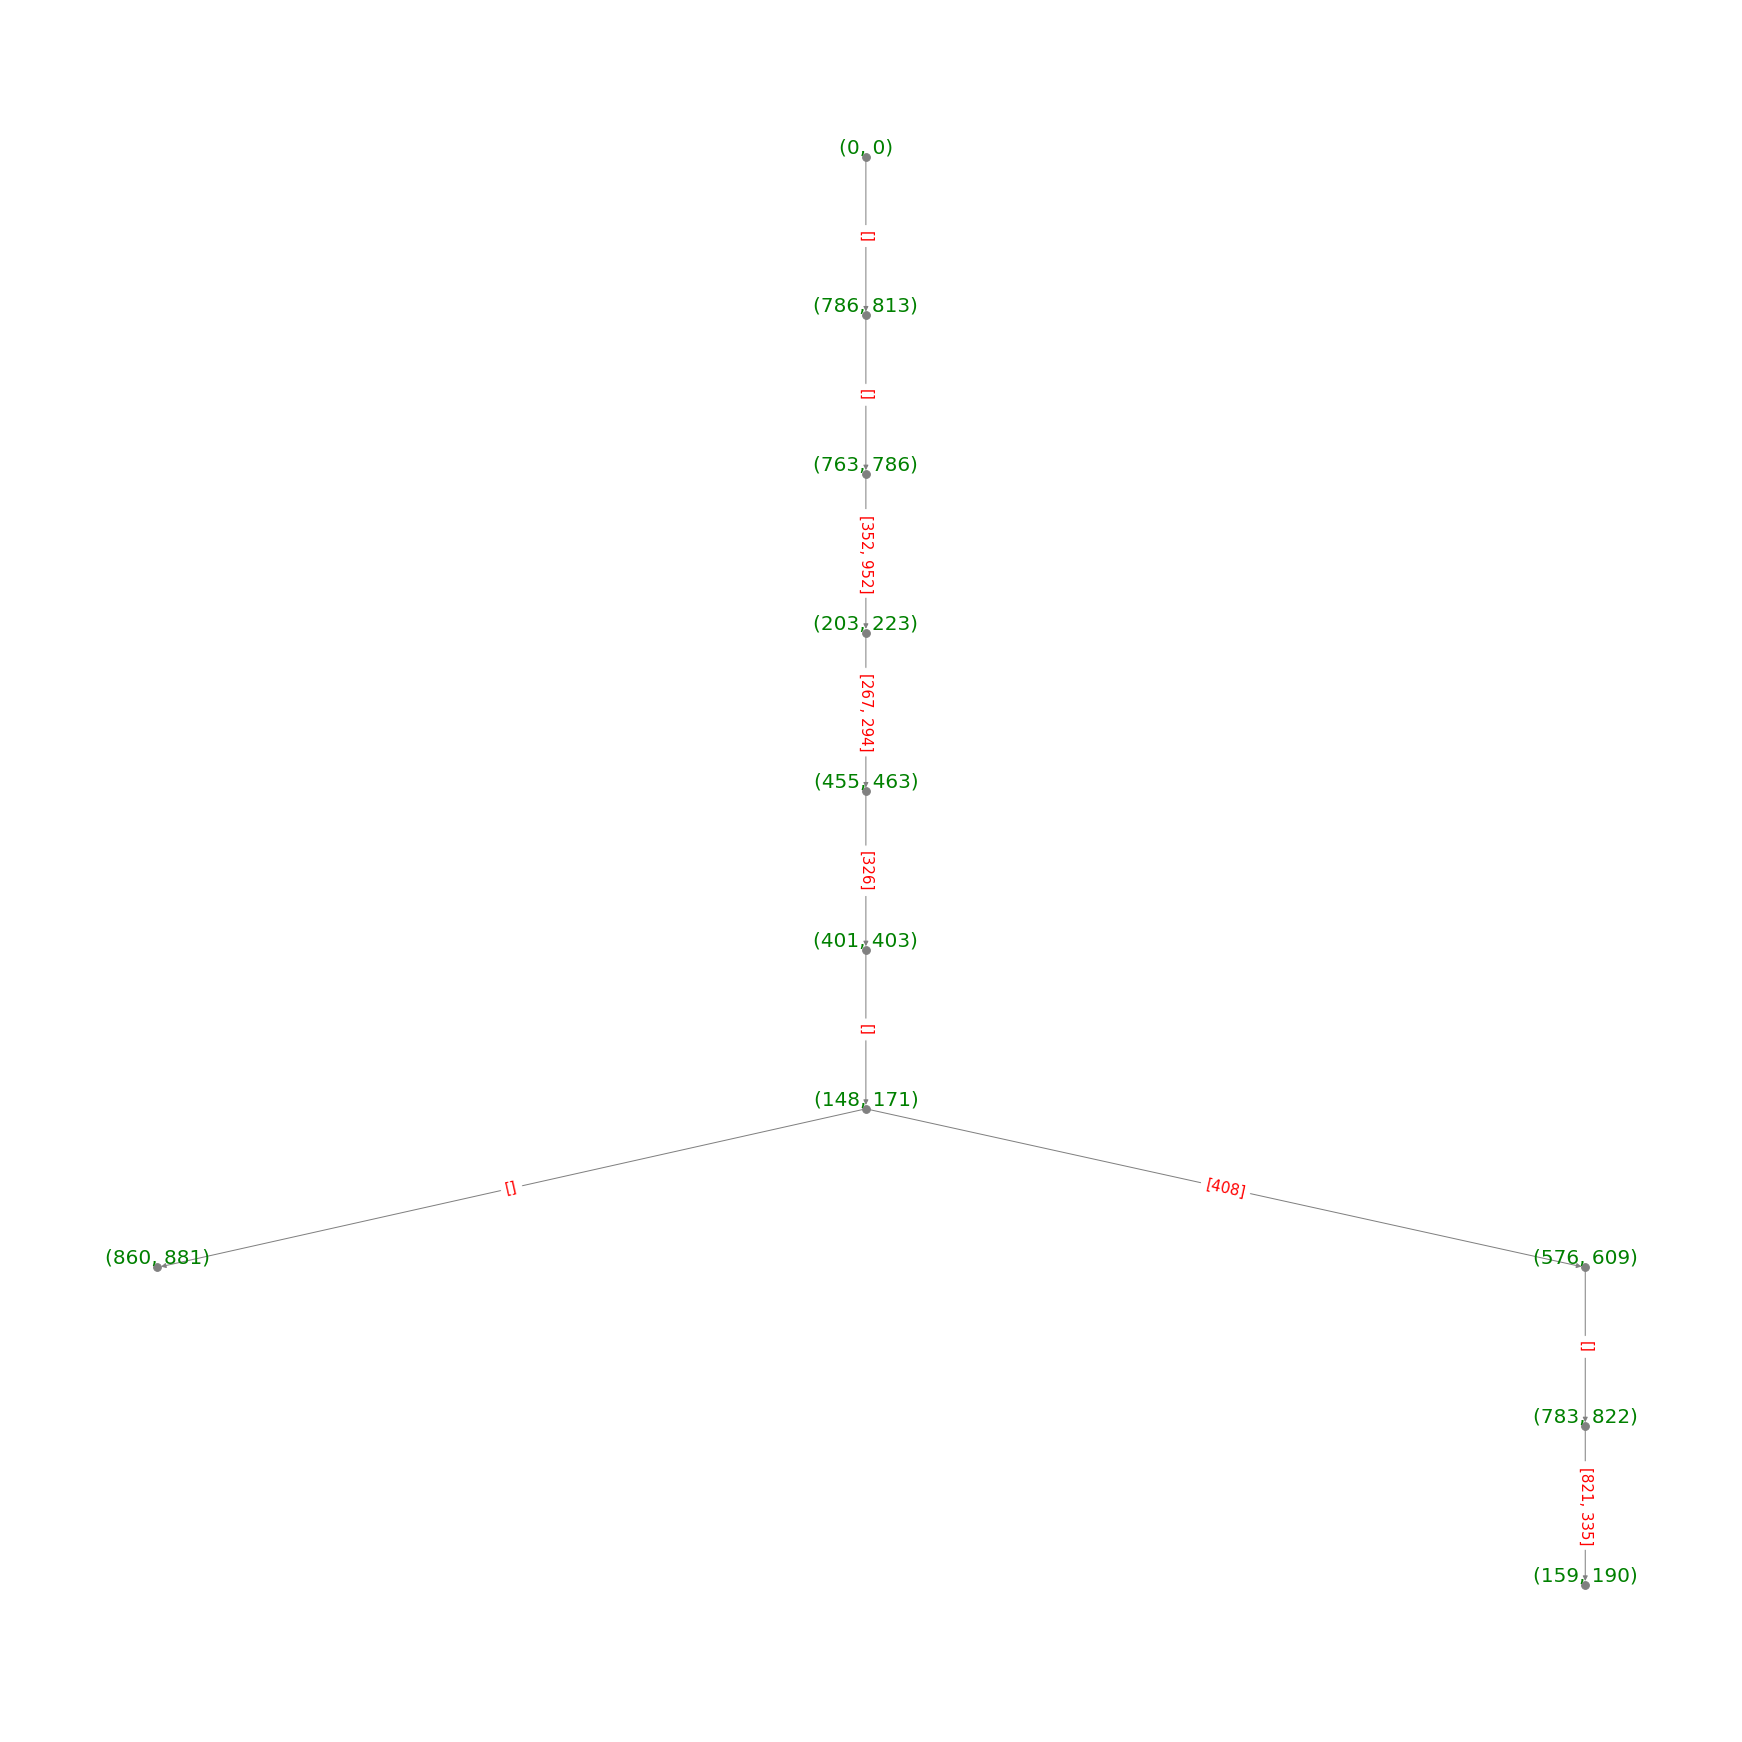

In [8]:
"""
DRAW TREE + SNVs 
"""

from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx 
import json
# Draw inferred tree 
plt.figure(3, figsize=(24, 24))
pos = graphviz_layout(model.tree.cn_event_tree, prog="dot")
nx.draw(model.tree.cn_event_tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")


edge_dict = {} 
for edge in model.tree.cn_event_tree.edges: 
    edge_dict[edge] = json.dumps(list(model.tree.node_to_snvs[edge[1]]))
nx.draw_networkx_edge_labels(
    model.tree.cn_event_tree, pos,
    edge_labels=edge_dict,
    font_color='red', font_size = 15
)
plt.show()

In [12]:
cells, cc_matrix = sample_cells_data(clusters=10, cluster_size=100, model=model, ctxt=ctxt, random_attachment=True)

In [16]:
cells.d

array([[ 7., 10.,  5., ...,  4.,  9.,  7.],
       [ 6.,  8.,  4., ...,  4.,  7., 10.],
       [ 6.,  6.,  4., ...,  7.,  5., 10.],
       ...,
       [ 7.,  6.,  5., ...,  4.,  2.,  4.],
       [ 8.,  7.,  7., ...,  7.,  4.,  5.],
       [ 6.,  7.,  6., ..., 10.,  4.,  5.]])

In [17]:
cells.b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
cells.attachment

[(203, 223),
 (0, 0),
 (401, 403),
 (783, 822),
 (783, 822),
 (860, 881),
 (203, 223),
 (860, 881),
 (786, 813),
 (148, 171)]